<a href="https://colab.research.google.com/github/amfolity/interpretability/blob/main/SoftmaxProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
def adaptive_temperature_softmax(logits):
  original_probs = jax.nn.softmax(logits)
  poly_fit = jnp.array([-0.037, 0.481, -2.3, 4.917, -1.791]) # see Figure 5
  entropy = jnp.sum(-original_probs * jnp.log(original_probs + 1e-9), axis=-1, keepdims=True) # compute the Shannon entropy
  beta = jnp.where( # beta = 1 / theta
                   entropy > 0.5, # don’t overcorrect low-entropy heads
  jnp.maximum(jnp.polyval(poly_fit, entropy), 1.0), # never increase entropy
  1.0)
return jax.nn.softmax(logits * beta)

hi


In [ ]:
import transformers

In [ ]:
model_name = 'google/gemma-2-2b-it'


In [ ]:
from huggingface_hub import login
login()

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [ ]:
model = transformers.AutoModelForCausalLM.from_pretrained(model_name)

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

In [ ]:
for param in model.parameters():
  param.requires_grad = False

In [ ]:
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

In [ ]:
import torch
prompt = ''

In [ ]:
batch = tokenizer(prompt, return_tensors='pt', return_token_type_ids=False)
for i in range(10):
  next_token = model(**batch).logits[0, -1].argmax(-1).reshape(1, 1)
  batch['input_ids'] = torch.cat([batch['input_ids'], next_token], dim=-1)
  batch['attention_mask'] = torch.cat([batch['attention_mask'], torch.ones_like(next_token)], dim=-1)

print(tokenizer.decode(batch['input_ids'][0]))

NameError: name 'tokenizer' is not defined

In [ ]:
batch

{'input_ids': tensor([[     2, 235280,   4320,   8426,  25341]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import jax.numpy as jnp
from flax import linen as nn
from typing import Callable
class Model(nn.Module):
  def __init__(self, n_classes, n_feats, activation):
    super().__init__()
  n_classes = n_classes # 10
  n_feats = n_feats # 128
  activation = nn.gelu


def __call__(self, x, q):
  x = nn.Dense(features=self.n_feats)(x)
  x = self.activation(x)
  x = nn.Dense(features=self.n_feats)(x)
  x = self.activation(x)
  q = nn.Dense(features=self.n_feats)(q)
  q = self.activation(q)
  q = nn.Dense(features=self.n_feats)(q)
  x = nn.MultiHeadDotProductAttention(
  num_heads=1,
  qkv_features=self.n_feats)(
  inputs_q=q,
  inputs_kv=x)
  x = nn.Dense(features=self.n_feats)(jnp.squeeze(x, -2))
  x = self.activation(x)
  x = nn.Dense(features=self.n_classes)(x)
  return x

In [13]:
from copy import deepcopy
import math
weights_log = []

# Efficient implementation equivalent to the following:
def custom_scaled_dot_product_attention(query, key, value, attn_mask=None, dropout_p=0.0,
        is_causal=False, scale=None, enable_gqa=False) -> torch.Tensor:
    L, S = query.size(-2), key.size(-2)
    scale_factor = 1 / math.sqrt(query.size(-1)) if scale is None else scale
    attn_bias = torch.zeros(L, S, dtype=query.dtype, device=query.device)
    if is_causal:
        assert attn_mask is None
        temp_mask = torch.ones(L, S, dtype=torch.bool).tril(diagonal=0)
        attn_bias.masked_fill_(temp_mask.logical_not(), float("-inf"))
        attn_bias.to(query.dtype)

    if attn_mask is not None:
        if attn_mask.dtype == torch.bool:
            attn_bias.masked_fill_(attn_mask.logical_not(), float("-inf"))
        else:
            attn_bias = attn_mask + attn_bias

    if enable_gqa:
        key = key.repeat_interleave(query.size(-3)//key.size(-3), -3)
        value = value.repeat_interleave(query.size(-3)//value.size(-3), -3)

    attn_weight = query @ key.transpose(-2, -1) * scale_factor
    attn_weight += attn_bias
    attn_weight = torch.softmax(attn_weight, dim=-1)
    attn_weight = torch.dropout(attn_weight, dropout_p, train=True)
    weights_log.append(attn_weight.detach().cpu().numpy())
    return attn_weight @ value

In [3]:
import torch
class Model(nn.Module):
  def __init__(self, n_classes=10, n_feats=128, activation=nn.GELU()):
    super().__init__()
    self.n_classes = n_classes
    self.n_feats = n_feats
    self.activation = activation
    self.fc1 = nn.Linear(in_features=self.n_classes + 1, out_features=self.n_feats)
    self.fc2 = nn.Linear(in_features=self.n_feats, out_features=self.n_feats)
    self.fc3 = nn.Linear(in_features=self.n_feats, out_features=self.n_feats)
    self.fc4 = nn.Linear(in_features=self.n_feats, out_features=self.n_feats)
    self.q_proj = nn.Linear(in_features=self.n_feats, out_features=self.n_feats, bias=False)
    self.k_proj = nn.Linear(in_features=self.n_feats, out_features=self.n_feats, bias=False)
    self.v_proj = nn.Linear(in_features=self.n_feats, out_features=self.n_feats, bias=False)

    self.fc5 = nn.Linear(in_features=self.n_feats, out_features=self.n_feats)
    self.fc6 = nn.Linear(in_features=self.n_feats, out_features=self.n_classes)
    self.attention_function = F.scaled_dot_product_attention


  def forward(self, x, q):
    x = self.activation(self.fc1(x))
    x = self.activation(self.fc2(x))
    q = self.activation(self.fc3(q))
    q = self.fc4(q)
    k = self.k_proj(x)
    q = self.q_proj(q)
    v = self.v_proj(x)

    #print(q.shape)
    ##print(x.unsqueeze(-3).shape)
    #print(x.shape)

    x = self.attention_function(q.unsqueeze(-3), k.unsqueeze(-3), v.unsqueeze(-3), is_causal=False)

    #print(x.shape)
    #print(x.squeeze(-2).squeeze(-2).shape)

    x = self.fc6(self.activation(self.fc5(x.squeeze(-2).squeeze(-2))))

    #print(x.shape)
    return x

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = torch.float32 if device=='cuda' else torch.float32

In [5]:
batch_size = 128  # Number of samples in the batch
input_dim = 128   # Number of features per sample
n = 16
num_classes = 10
# Generate a batch of random values in the range [0,1)

rho = torch.rand(batch_size, n, 1)
cla = torch.randint(0, num_classes, (batch_size, n))
one_hot = torch.zeros(batch_size, n, num_classes)
one_hot.scatter_(2, cla.unsqueeze(2), 1)
X = torch.cat([rho, one_hot], dim=-1)
Y = cla.take(torch.argmax(rho.squeeze(-1), dim=-1))
q = torch.rand(batch_size, 1, input_dim)



#q =  torch.rand(1, input_dim)
model = Model(n_classes=num_classes, n_feats=input_dim, activation=nn.GELU())
#model(X,q)

In [6]:
model.to(device).to(dtype)

Model(
  (activation): GELU(approximate='none')
  (fc1): Linear(in_features=11, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=128, bias=True)
  (q_proj): Linear(in_features=128, out_features=128, bias=False)
  (k_proj): Linear(in_features=128, out_features=128, bias=False)
  (v_proj): Linear(in_features=128, out_features=128, bias=False)
  (fc5): Linear(in_features=128, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=10, bias=True)
)

In [7]:
model.fc3.weight

Parameter containing:
tensor([[-0.0491,  0.0636, -0.0096,  ..., -0.0078,  0.0702, -0.0154],
        [ 0.0355,  0.0765,  0.0079,  ..., -0.0739,  0.0314, -0.0162],
        [ 0.0538, -0.0293,  0.0447,  ...,  0.0838,  0.0756,  0.0020],
        ...,
        [-0.0335, -0.0238,  0.0526,  ..., -0.0199,  0.0628, -0.0785],
        [-0.0485,  0.0706,  0.0218,  ...,  0.0252,  0.0380, -0.0250],
        [ 0.0755, -0.0488, -0.0282,  ...,  0.0504,  0.0671, -0.0257]],
       device='cuda:0', requires_grad=True)

In [8]:
model.fc3.weight

Parameter containing:
tensor([[-0.0491,  0.0636, -0.0096,  ..., -0.0078,  0.0702, -0.0154],
        [ 0.0355,  0.0765,  0.0079,  ..., -0.0739,  0.0314, -0.0162],
        [ 0.0538, -0.0293,  0.0447,  ...,  0.0838,  0.0756,  0.0020],
        ...,
        [-0.0335, -0.0238,  0.0526,  ..., -0.0199,  0.0628, -0.0785],
        [-0.0485,  0.0706,  0.0218,  ...,  0.0252,  0.0380, -0.0250],
        [ 0.0755, -0.0488, -0.0282,  ...,  0.0504,  0.0671, -0.0257]],
       device='cuda:0', requires_grad=True)

In [9]:
torch.max(model.fc3.weight)

tensor(0.0884, device='cuda:0', grad_fn=<MaxBackward1>)

In [10]:
import random
import tqdm
opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.000)
#opt = torch.optim.Adam(model.parameters(), lr=0.01)
q = torch.rand(1, 1, input_dim, device=device, dtype=dtype).tile((batch_size, 1, 1))


for epoch in tqdm.trange(100000):
  n = random.randint(5, 16)
  rho = torch.rand(batch_size, n, 1, device=device, dtype=dtype)
  cla = torch.randint(0, num_classes, (batch_size, n), device=device)
  one_hot = torch.zeros(batch_size, n, num_classes, device=device, dtype=dtype)
  one_hot.scatter_(2, cla.unsqueeze(2), 1)
  X = torch.cat([rho, one_hot], dim=-1)
  Y = cla.take_along_dim(torch.argmax(rho.squeeze(-1), dim=-1).unsqueeze(-1), dim=-1).squeeze(-1)
  #q = torch.rand(batch_size, 1, input_dim, device=device, dtype=dtype)
  opt.zero_grad()
  outputs = model(X,q) ## what is X and q here, do we need to generate each tim
  loss = F.cross_entropy(outputs, Y)
  if epoch % 1000 == 0:
    print("loss is {}".format(loss.item()))
  loss.backward()
  opt.step()

  0%|          | 0/100000 [00:00<?, ?it/s]

loss is 2.3049211502075195


  1%|          | 1035/100000 [00:04<07:05, 232.58it/s]

loss is 0.06548206508159637


  2%|▏         | 2043/100000 [00:08<06:36, 247.01it/s]

loss is 0.1287085860967636


  3%|▎         | 3027/100000 [00:12<07:22, 218.98it/s]

loss is 0.05989135801792145


  4%|▍         | 4030/100000 [00:16<06:41, 238.80it/s]

loss is 0.07901369780302048


  5%|▌         | 5033/100000 [00:20<06:05, 259.59it/s]

loss is 0.026602977886795998


  6%|▌         | 6030/100000 [00:24<06:32, 239.20it/s]

loss is 0.06263602524995804


  7%|▋         | 7030/100000 [00:27<05:19, 290.62it/s]

loss is 0.040228165686130524


  8%|▊         | 8026/100000 [00:30<04:39, 329.46it/s]

loss is 0.030129920691251755


  9%|▉         | 9049/100000 [00:34<04:03, 373.80it/s]

loss is 0.03181347995996475


 10%|█         | 10077/100000 [00:36<04:04, 367.04it/s]

loss is 0.14736327528953552


 11%|█         | 11039/100000 [00:39<03:57, 373.99it/s]

loss is 0.0016655479557812214


 12%|█▏        | 12039/100000 [00:42<03:56, 371.30it/s]

loss is 0.0185551755130291


 13%|█▎        | 13052/100000 [00:45<04:09, 347.87it/s]

loss is 0.07343964278697968


 14%|█▍        | 14049/100000 [00:47<03:50, 372.23it/s]

loss is 0.046474382281303406


 15%|█▌        | 15027/100000 [00:51<05:39, 250.49it/s]

loss is 0.009593450464308262


 16%|█▌        | 16040/100000 [00:55<06:26, 217.13it/s]

loss is 0.015495575964450836


 17%|█▋        | 17046/100000 [00:59<05:13, 265.01it/s]

loss is 0.014473680406808853


 18%|█▊        | 18035/100000 [01:04<05:20, 255.41it/s]

loss is 0.03906000405550003


 19%|█▉        | 19032/100000 [01:07<04:54, 274.82it/s]

loss is 0.000722352706361562


 20%|██        | 20040/100000 [01:11<05:14, 254.15it/s]

loss is 0.009106352925300598


 21%|██        | 21028/100000 [01:15<05:51, 224.55it/s]

loss is 0.05374972149729729


 22%|██▏       | 22022/100000 [01:19<05:48, 223.78it/s]

loss is 0.003734039142727852


 23%|██▎       | 23042/100000 [01:23<04:46, 268.36it/s]

loss is 0.0011737165041267872


 24%|██▍       | 24030/100000 [01:28<04:46, 265.28it/s]

loss is 0.04057164490222931


 25%|██▌       | 25029/100000 [01:32<04:48, 259.68it/s]

loss is 0.01764615811407566


 26%|██▌       | 26021/100000 [01:36<05:39, 217.79it/s]

loss is 0.007192733697593212


 27%|██▋       | 27033/100000 [01:40<04:48, 252.57it/s]

loss is 0.002230764366686344


 28%|██▊       | 28039/100000 [01:44<05:22, 223.24it/s]

loss is 3.5385175578994676e-05


 29%|██▉       | 29069/100000 [01:48<03:20, 354.42it/s]

loss is 0.015634307637810707


 30%|███       | 30074/100000 [01:51<03:06, 374.98it/s]

loss is 0.004765503574162722


 31%|███       | 31045/100000 [01:54<04:12, 273.55it/s]

loss is 0.0017670677043497562


 32%|███▏      | 32055/100000 [01:57<03:04, 367.50it/s]

loss is 0.07751262187957764


 33%|███▎      | 33046/100000 [01:59<02:59, 372.89it/s]

loss is 0.0053020683117210865


 34%|███▍      | 34042/100000 [02:02<02:53, 379.08it/s]

loss is 0.0010147503344342113


 35%|███▌      | 35037/100000 [02:05<03:40, 294.33it/s]

loss is 0.052033793181180954


 36%|███▌      | 36051/100000 [02:08<02:54, 366.21it/s]

loss is 0.00957135483622551


 37%|███▋      | 37055/100000 [02:11<02:50, 369.53it/s]

loss is 0.019433630630373955


 38%|███▊      | 38041/100000 [02:13<02:45, 374.10it/s]

loss is 0.025064168497920036


 39%|███▉      | 39068/100000 [02:16<02:46, 366.17it/s]

loss is 0.0022028039675205946


 40%|████      | 40074/100000 [02:19<02:42, 368.71it/s]

loss is 0.005278702825307846


 41%|████      | 41058/100000 [02:22<02:40, 367.70it/s]

loss is 0.058076467365026474


 42%|████▏     | 42037/100000 [02:25<02:35, 373.84it/s]

loss is 0.00043448869837448


 43%|████▎     | 43070/100000 [02:27<02:31, 376.94it/s]

loss is 0.012925310991704464


 44%|████▍     | 44056/100000 [02:31<02:38, 353.65it/s]

loss is 0.003891940228641033


 45%|████▌     | 45043/100000 [02:33<02:26, 376.38it/s]

loss is 0.015811314806342125


 46%|████▌     | 46040/100000 [02:36<02:28, 364.29it/s]

loss is 0.019103363156318665


 47%|████▋     | 47039/100000 [02:39<02:20, 377.27it/s]

loss is 0.00020263041369616985


 48%|████▊     | 48029/100000 [02:42<03:01, 286.99it/s]

loss is 0.012285377830266953


 49%|████▉     | 49061/100000 [02:44<02:13, 382.33it/s]

loss is 0.004485677927732468


 50%|█████     | 50065/100000 [02:47<02:11, 378.64it/s]

loss is 0.015884364023804665


 51%|█████     | 51069/100000 [02:50<02:11, 371.61it/s]

loss is 0.030459055677056313


 52%|█████▏    | 52040/100000 [02:53<02:41, 297.24it/s]

loss is 0.05170004814863205


 53%|█████▎    | 53073/100000 [02:56<02:04, 376.00it/s]

loss is 0.00012931777746416628


 54%|█████▍    | 54065/100000 [02:58<02:06, 362.73it/s]

loss is 0.025050587952136993


 55%|█████▌    | 55062/100000 [03:01<01:57, 381.09it/s]

loss is 0.024279622361063957


 56%|█████▌    | 56062/100000 [03:04<01:55, 378.84it/s]

loss is 0.010684015229344368


 57%|█████▋    | 57044/100000 [03:07<02:01, 353.39it/s]

loss is 0.011538145132362843


 58%|█████▊    | 58073/100000 [03:10<01:52, 371.24it/s]

loss is 8.22550937300548e-05


 59%|█████▉    | 59066/100000 [03:12<01:49, 374.18it/s]

loss is 0.002249006414785981


 60%|██████    | 60057/100000 [03:15<01:47, 370.84it/s]

loss is 0.04868001118302345


 61%|██████    | 61074/100000 [03:18<01:55, 336.97it/s]

loss is 0.00397044513374567


 62%|██████▏   | 62038/100000 [03:21<01:43, 367.94it/s]

loss is 3.5234144888818264e-05


 63%|██████▎   | 63039/100000 [03:23<01:38, 374.00it/s]

loss is 0.021394751965999603


 64%|██████▍   | 64066/100000 [03:26<01:35, 377.66it/s]

loss is 0.002338437596336007


 65%|██████▌   | 65041/100000 [03:29<01:56, 299.83it/s]

loss is 0.01212496217340231


 66%|██████▌   | 66047/100000 [03:32<01:30, 374.52it/s]

loss is 0.018164314329624176


 67%|██████▋   | 67076/100000 [03:35<01:27, 377.86it/s]

loss is 1.9258293832535855e-05


 68%|██████▊   | 68066/100000 [03:37<01:27, 365.06it/s]

loss is 0.013427047058939934


 69%|██████▉   | 69053/100000 [03:40<01:38, 314.17it/s]

loss is 0.005240058060735464


 70%|███████   | 70049/100000 [03:43<01:20, 371.43it/s]

loss is 0.0032249344512820244


 71%|███████   | 71045/100000 [03:46<01:18, 370.12it/s]

loss is 0.0005347435362637043


 72%|███████▏  | 72056/100000 [03:48<01:14, 374.33it/s]

loss is 0.002054638462141156


 73%|███████▎  | 73050/100000 [03:51<01:11, 376.90it/s]

loss is 3.7140878248465015e-06


 74%|███████▍  | 74065/100000 [03:54<01:09, 370.98it/s]

loss is 0.04186084121465683


 75%|███████▌  | 75061/100000 [03:57<01:07, 369.52it/s]

loss is 0.0003226888075005263


 76%|███████▌  | 76053/100000 [04:00<01:03, 375.76it/s]

loss is 0.003961729351431131


 77%|███████▋  | 77059/100000 [04:02<00:59, 384.46it/s]

loss is 0.00030292183510027826


 78%|███████▊  | 78052/100000 [04:06<01:22, 265.54it/s]

loss is 0.0013452157145366073


 79%|███████▉  | 79043/100000 [04:08<00:56, 372.20it/s]

loss is 0.044702909886837006


 80%|████████  | 80044/100000 [04:11<00:53, 373.47it/s]

loss is 0.0013799895532429218


 81%|████████  | 81039/100000 [04:14<00:51, 367.10it/s]

loss is 0.010714820586144924


 82%|████████▏ | 82062/100000 [04:17<00:59, 300.69it/s]

loss is 2.384595609328244e-05


 83%|████████▎ | 83051/100000 [04:19<00:45, 374.16it/s]

loss is 0.00010973462485708296


 84%|████████▍ | 84050/100000 [04:22<00:41, 381.43it/s]

loss is 4.811401595361531e-05


 85%|████████▌ | 85046/100000 [04:25<00:40, 372.81it/s]

loss is 0.014068624004721642


 86%|████████▌ | 86054/100000 [04:27<00:36, 379.86it/s]

loss is 9.199644409818575e-06


 87%|████████▋ | 87070/100000 [04:31<00:35, 368.55it/s]

loss is 0.024203132838010788


 88%|████████▊ | 88066/100000 [04:33<00:32, 365.61it/s]

loss is 0.0045014964416623116


 89%|████████▉ | 89061/100000 [04:36<00:29, 374.99it/s]

loss is 0.017459817230701447


 90%|█████████ | 90062/100000 [04:39<00:25, 383.55it/s]

loss is 0.0007296021212823689


 91%|█████████ | 91044/100000 [04:42<00:25, 345.30it/s]

loss is 0.003835550043731928


 92%|█████████▏| 92072/100000 [04:45<00:21, 374.85it/s]

loss is 0.02326592244207859


 93%|█████████▎| 93070/100000 [04:47<00:18, 379.71it/s]

loss is 0.009226345457136631


 94%|█████████▍| 94074/100000 [04:50<00:15, 373.30it/s]

loss is 1.1240462299610954e-05


 95%|█████████▌| 95036/100000 [04:53<00:17, 288.50it/s]

loss is 1.373411578242667e-05


 96%|█████████▌| 96057/100000 [04:56<00:10, 368.67it/s]

loss is 0.007079233415424824


 97%|█████████▋| 97045/100000 [04:58<00:08, 369.37it/s]

loss is 2.1411021862149937e-06


 98%|█████████▊| 98072/100000 [05:01<00:05, 372.63it/s]

loss is 6.609575939364731e-05


 99%|█████████▉| 99041/100000 [05:04<00:03, 299.66it/s]

loss is 0.011417112313210964


100%|██████████| 100000/100000 [05:07<00:00, 325.34it/s]


In [14]:
model.attention_function = custom_scaled_dot_product_attention

In [15]:
for pw2 in range(4, 15, 1):
  n = 1 << pw2
  rho = torch.rand(batch_size, n, 1, device=device, dtype=dtype)
  cla = torch.randint(0, num_classes, (batch_size, n), device=device)
  one_hot = torch.zeros(batch_size, n, num_classes, device=device, dtype=dtype)
  one_hot.scatter_(2, cla.unsqueeze(2), 1)
  X = torch.cat([rho, one_hot], dim=-1)
  Y = cla.take_along_dim(torch.argmax(rho.squeeze(-1), dim=-1).unsqueeze(-1), dim=-1).squeeze(-1)
  #q = torch.rand(batch_size, 1, input_dim, device=device, dtype=dtype)
  outputs = model(X,q) ## what is X and q here, do we need to generate each tim
  loss = F.cross_entropy(outputs, Y)
  print("loss is {}".format(loss.item()))


loss is 0.00018729144358076155
loss is 8.018460357561707e-05
loss is 0.041696395725011826
loss is 0.08072146773338318
loss is 0.12078747153282166
loss is 0.19038978219032288
loss is 0.5408046245574951
loss is 0.6475212574005127
loss is 1.4160465002059937
loss is 1.7798912525177002
loss is 2.1108317375183105


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
len(weights_log)

11

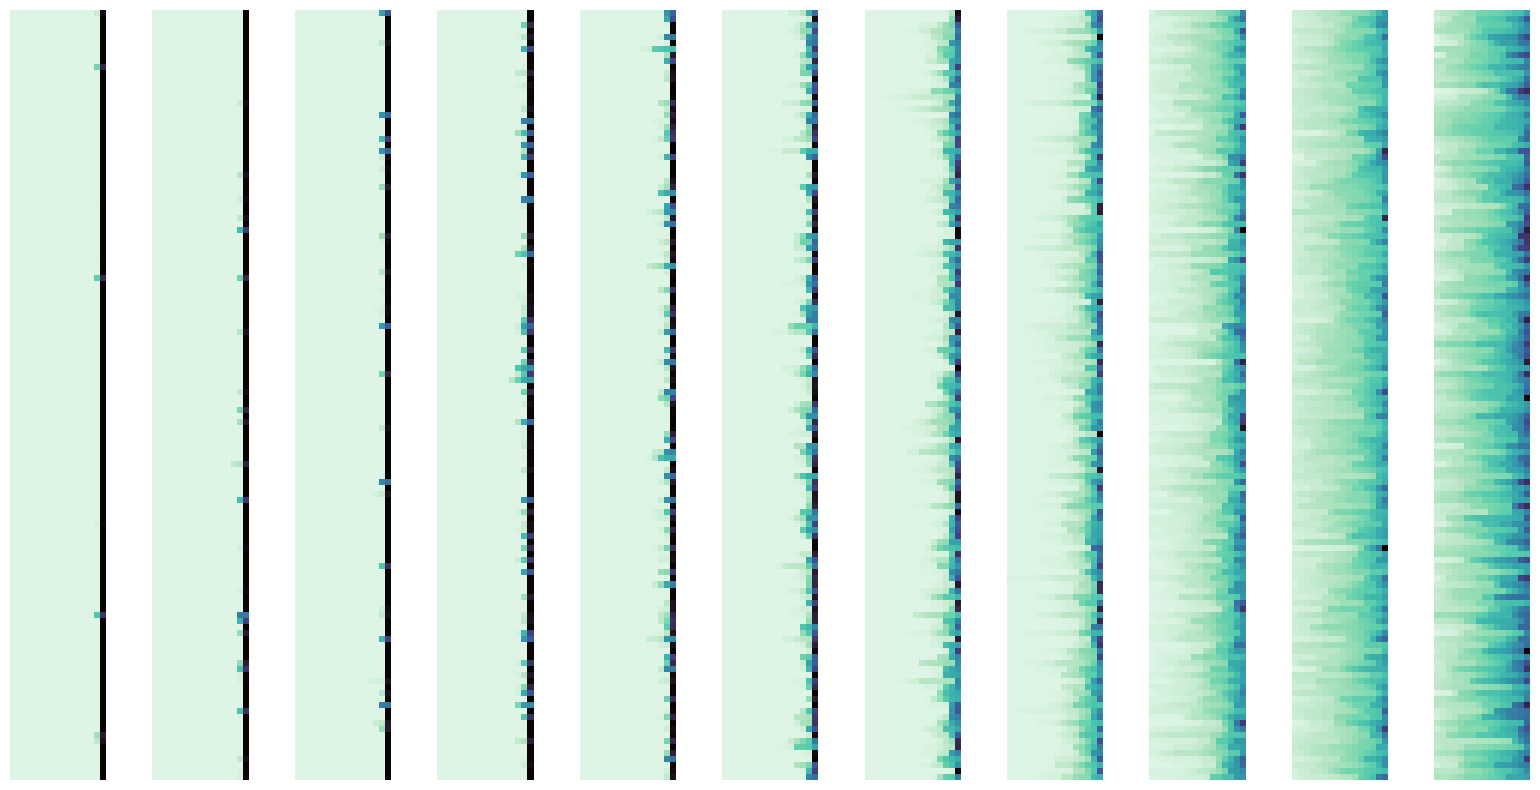

In [30]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(1, 11, figsize=(16, 8))

# Plot each heatmap
for i, ax in enumerate(axes.flat):
    data = weights_log[i].squeeze()
    np.sort(data)
    data = np.sort(data)[:, -16:]
    sns.heatmap(-data, ax=ax, cbar=False, square=True, cmap='mako')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


In [60]:
idx = 101
print(X[idx])
print(Y[idx])

tensor([[0.6077, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000, 0.0000],
        [0.4161, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0000],
        [0.7344, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.8621, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.7682, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.7123, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000, 0.0000],
        [0.0200, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000],
        [0.5742, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000]], device='cuda:0')
tensor(1, device='cuda:0')


In [26]:
print(rho[idx])
print(cla[idx])

tensor([[0.5275],
        [0.1077],
        [0.9811],
        [0.0509],
        [0.9447],
        [0.3840],
        [0.1458],
        [0.2467]], device='cuda:0')
tensor([0, 3, 0, 4, 4, 4, 1, 6], device='cuda:0')


In [29]:
rho.shape

torch.Size([128, 8, 1])

In [40]:
torch.argmax(rho.squeeze(-1), dim=-1).unsqueeze(-1)

tensor([[2],
        [2],
        [2],
        [2],
        [0],
        [0],
        [0],
        [4],
        [4],
        [5],
        [6],
        [2],
        [7],
        [0],
        [5],
        [3],
        [3],
        [3],
        [4],
        [4],
        [2],
        [5],
        [5],
        [4],
        [5],
        [4],
        [1],
        [1],
        [0],
        [4],
        [0],
        [5],
        [7],
        [7],
        [7],
        [6],
        [6],
        [5],
        [1],
        [5],
        [3],
        [4],
        [7],
        [5],
        [2],
        [0],
        [1],
        [4],
        [2],
        [3],
        [0],
        [3],
        [2],
        [5],
        [1],
        [2],
        [5],
        [6],
        [7],
        [7],
        [3],
        [0],
        [7],
        [4],
        [2],
        [6],
        [6],
        [5],
        [3],
        [3],
        [6],
        [1],
        [0],
        [5],
        [7],
        [0],
        [7],

In [46]:
cla.take_along_dim(torch.argmax(rho.squeeze(-1), dim=-1).unsqueeze(-1), dim=-1).squeeze(-1)

tensor([6, 8, 4, 0, 6, 1, 6, 9, 2, 7, 1, 3, 8, 0, 2, 0, 4, 6, 1, 7, 8, 0, 1, 2,
        3, 9, 8, 7, 0, 9, 4, 0, 0, 5, 3, 1, 5, 5, 6, 1, 9, 1, 2, 3, 9, 9, 5, 7,
        1, 8, 4, 2, 1, 9, 6, 4, 3, 8, 6, 2, 0, 8, 6, 1, 6, 5, 3, 4, 2, 7, 3, 2,
        0, 0, 6, 6, 4, 0, 4, 8, 6, 9, 3, 0, 8, 4, 5, 7, 9, 0, 2, 5, 3, 7, 7, 8,
        0, 3, 3, 5, 4, 9, 9, 8, 5, 9, 8, 4, 8, 7, 5, 3, 7, 4, 4, 9, 0, 1, 6, 4,
        4, 8, 0, 0, 8, 9, 0, 6], device='cuda:0')

In [ ]:
model(X,q)[6]

torch.Size([128, 1, 128])
torch.Size([128, 1, 7, 128])
torch.Size([128, 7, 128])
torch.Size([128, 1, 1, 128])
torch.Size([128, 128])
torch.Size([128, 10])


tensor([ 0.0326,  0.1267,  0.0637,  0.0893,  0.0409, -0.1043,  0.0812, -0.0475,
        -0.0947,  0.0971], device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
cla[0]

tensor([6, 7, 1, 0, 6, 8, 9, 0, 0, 4, 5, 0, 5, 3, 1, 8], device='cuda:0')

In [ ]:
torch.argmax(rho.squeeze(-1), dim=-1)

tensor([ 8,  3, 14,  6, 11, 10, 15,  4,  8, 10, 12,  1,  9,  0, 11, 13,  2,  9,
         6, 11,  9, 11,  2, 13, 15,  0,  9,  4,  1, 11, 10,  3,  4,  7,  4, 10,
        10, 13,  2,  8,  6,  4,  0,  9,  4, 12,  4,  2,  8,  0, 15,  3,  0,  1,
        15,  5,  9, 11,  1,  3,  2,  0,  3,  7])

In [ ]:
cla.take(torch.argmax(rho.squeeze(-1), dim=-1))

tensor([5, 2, 4, 0, 5, 5, 7, 8, 5, 5, 8, 5, 5, 2, 5, 6, 5, 5, 0, 5, 5, 5, 5, 6,
        7, 2, 5, 8, 5, 5, 5, 2, 8, 6, 8, 5, 5, 6, 5, 5, 0, 8, 2, 5, 8, 8, 8, 5,
        5, 2, 7, 2, 2, 5, 7, 4, 5, 5, 5, 2, 5, 2, 2, 6])

In [ ]:
outputs = model(batch, q)

AttributeError: module 'torch.nn' has no attribute 'MultiHeadDotProductAttention'

In [ ]:
outputs = model(**batch)
next_word_logits = outputs.logits[:, num_prompts : -1, :]
loss = F.cross_entropy(next_word_logits.flatten(0, 1), true_next_tokens.flatten(0, 1))

TypeError: Model(
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=128, bias=True)
  (fc6): Linear(in_features=10, out_features=10, bias=True)
) argument after ** must be a mapping, not Tensor

In [ ]:
while loss.item() > 0.1:
  model.zero_grad()
  opt.zero_grad()
  outputs = model(**batch)
  next_word_logits = outputs.logits[:, num_prompts : -1, :]
  true_next_tokens = batch['input_ids'][:, num_prompts + 1:]
  loss = F.cross_entropy(next_word_logits.flatten(0, 1), true_next_tokens.flatten(0, 1))
  print("loss is {}".format(loss))
  loss.backward()
  opt.step()


NameError: name 'loss' is not defined